## Importation des librairies

In [1]:
import itertools
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Scoring
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_squared_log_error

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

## Importation des données

In [2]:
train_test = pd.read_csv('train_test.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('reference.csv')

In [3]:
train_test['Date'] = pd.to_datetime(train_test['Date'])
train_test.head()

,Territory X Date,target,Territory,Date
0,Afghanistan X 1/22/20,0,Afghanistan,2020-01-22
1,Afghanistan X 1/23/20,0,Afghanistan,2020-01-23
2,Afghanistan X 1/24/20,0,Afghanistan,2020-01-24
3,Afghanistan X 1/25/20,0,Afghanistan,2020-01-25
4,Afghanistan X 1/26/20,0,Afghanistan,2020-01-26


In [4]:
train_test.tail()

,Territory X Date,target,Territory,Date
23612,Zimbabwe X 5/9/20,4,Zimbabwe,2020-05-09
23613,Zimbabwe X 5/10/20,4,Zimbabwe,2020-05-10
23614,Zimbabwe X 5/11/20,4,Zimbabwe,2020-05-11
23615,Zimbabwe X 5/12/20,4,Zimbabwe,2020-05-12
23616,Zimbabwe X 5/13/20,4,Zimbabwe,2020-05-13


In [5]:
train_test.Date.nunique()

113

In [6]:
train_test.Territory.nunique()

209

In [7]:
train['Date'] = pd.to_datetime(train['Date'])
train.head()

,Territory X Date,target,cases,Territory,Date
0,Afghanistan X 1/22/20,0,0,Afghanistan,2020-01-22
1,Afghanistan X 1/23/20,0,0,Afghanistan,2020-01-23
2,Afghanistan X 1/24/20,0,0,Afghanistan,2020-01-24
3,Afghanistan X 1/25/20,0,0,Afghanistan,2020-01-25
4,Afghanistan X 1/26/20,0,0,Afghanistan,2020-01-26


In [8]:
train.tail()

,Territory X Date,target,cases,Territory,Date
22149,Zimbabwe X 5/2/20,4,34,Zimbabwe,2020-05-02
22150,Zimbabwe X 5/3/20,4,34,Zimbabwe,2020-05-03
22151,Zimbabwe X 5/4/20,4,34,Zimbabwe,2020-05-04
22152,Zimbabwe X 5/5/20,4,34,Zimbabwe,2020-05-05
22153,Zimbabwe X 5/6/20,4,34,Zimbabwe,2020-05-06


In [9]:
train.Date.nunique()

106

In [10]:
test.head()

,Territory X Date,target
0,Afghanistan X 5/7/20,106
1,Afghanistan X 5/8/20,109
2,Afghanistan X 5/9/20,115
3,Afghanistan X 5/10/20,120
4,Afghanistan X 5/11/20,122


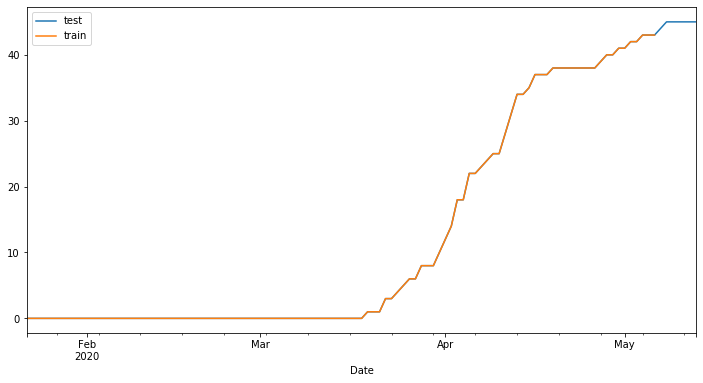

In [11]:
ax = train_test[train_test['Territory']=='Tunisia'].plot(x='Date',y='target',figsize=(12,6),label='test')
train[train['Territory']=='Tunisia'].plot(x='Date',y='target',ax=ax,label='train')

## Creating the time series

In [12]:
tsf = []
for t in train.Territory.unique():
    tsf.append(train_test[train_test['Territory']==t][['Date','target']].set_index('Date'))

In [13]:
ts = []
for t in train.Territory.unique():
    ts.append(train[train['Territory']==t][['Date','target']].set_index('Date'))
ts[0] 

,target
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-05-02,72
2020-05-03,85
2020-05-04,90


## Data Understanding

### Stationarity and Auto-correlation

In [14]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

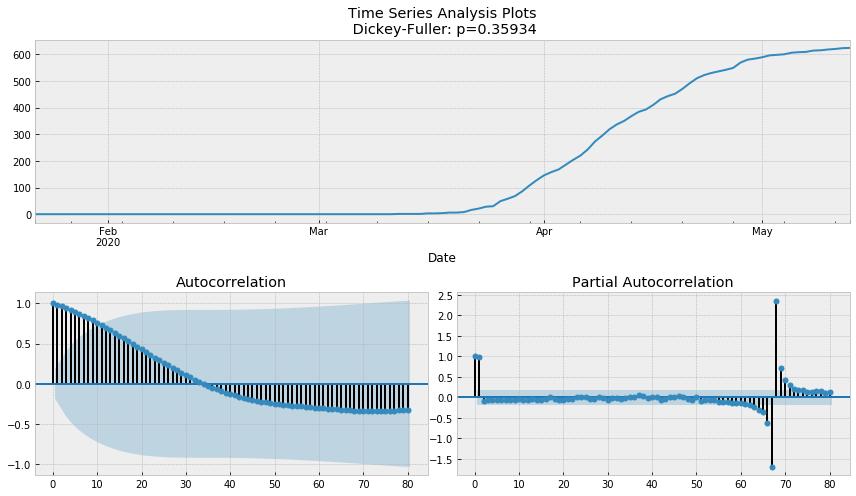

In [15]:
tsplot(tsf[10].target, lags=80)

interprétation : La corrélation tombe lentement à l'intervalle de confiance et donc il existe une forte autocorrélation (les instances consécutives sont dépendantes). De plus, pvalue > 0.05 => on accepte l'hypothèse nulle : La série est non stationnaire. On nécessite une différentiation avant l'application du modèle.

### Lag Plot

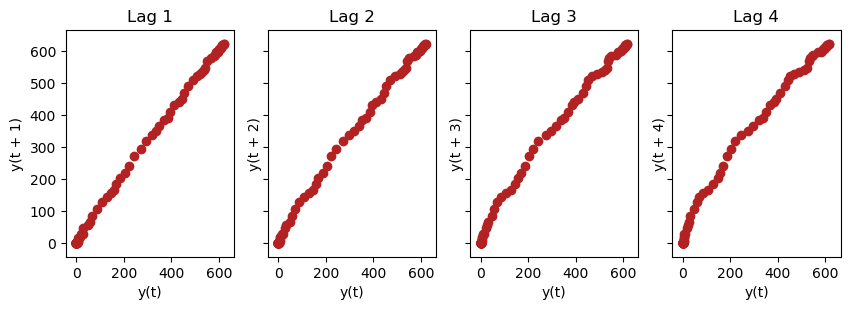

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(tsf[10].target, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))
plt.plot();

interprétation: On peut déduire d'après les graphes qu'il existe une forte corrélation entre les instances du temps y(t) avec les valeurs y(t+1), y(t+2), y(t+3) et y(t+4) ce qui confirme qu'on peut créer un modéle ARIMA qui est basé sur l'auto-corrélation.

## Decomposition

In [17]:
result = seasonal_decompose(tsf[10], model='additive')

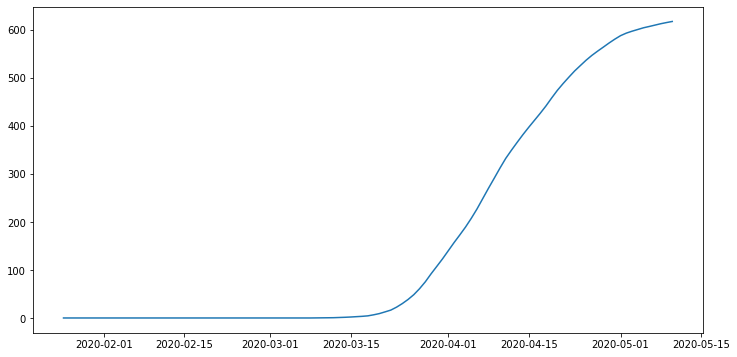

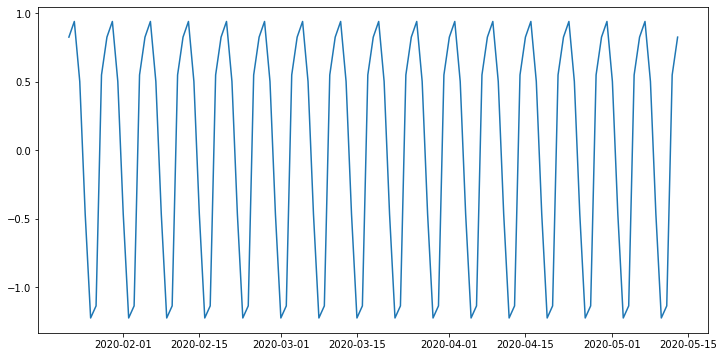

In [18]:
plt.figure(figsize=(12,6))
plt.plot(result.trend);
plt.figure(figsize=(12,6))
plt.plot(result.seasonal);

## Adjustment (Holt-Winters Model)

### Moving Average

In [19]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average")
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

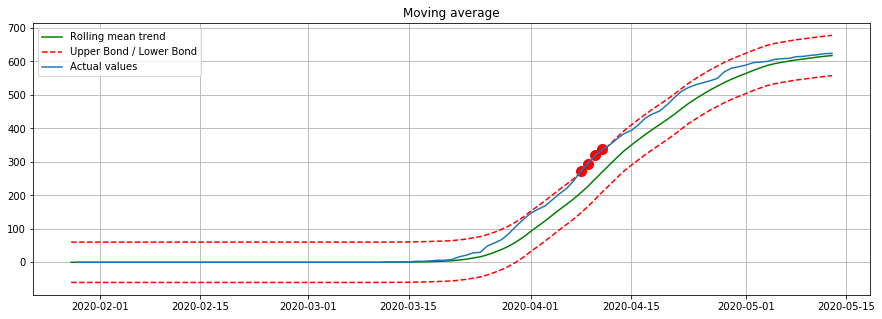

In [20]:
plotMovingAverage(tsf[10], 7, plot_intervals=True, plot_anomalies=True) 

### Exponential Smoothing

In [21]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

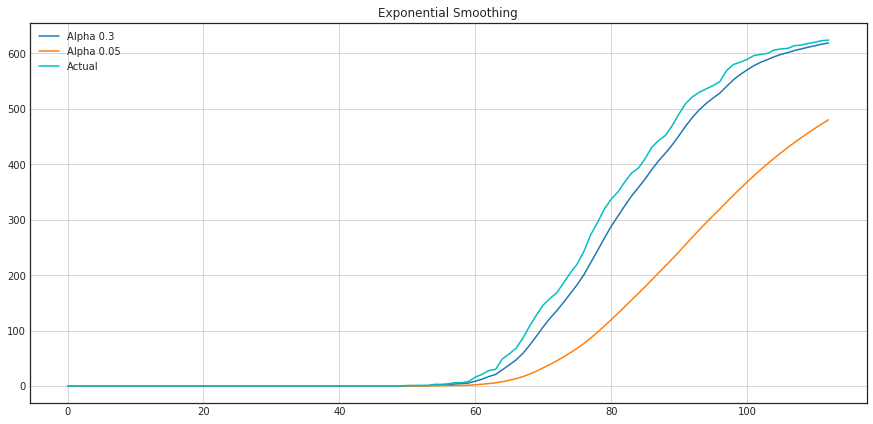

In [22]:
plotExponentialSmoothing(tsf[10].target, [0.3, 0.05])

### Double Exponential Smoothing

In [23]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

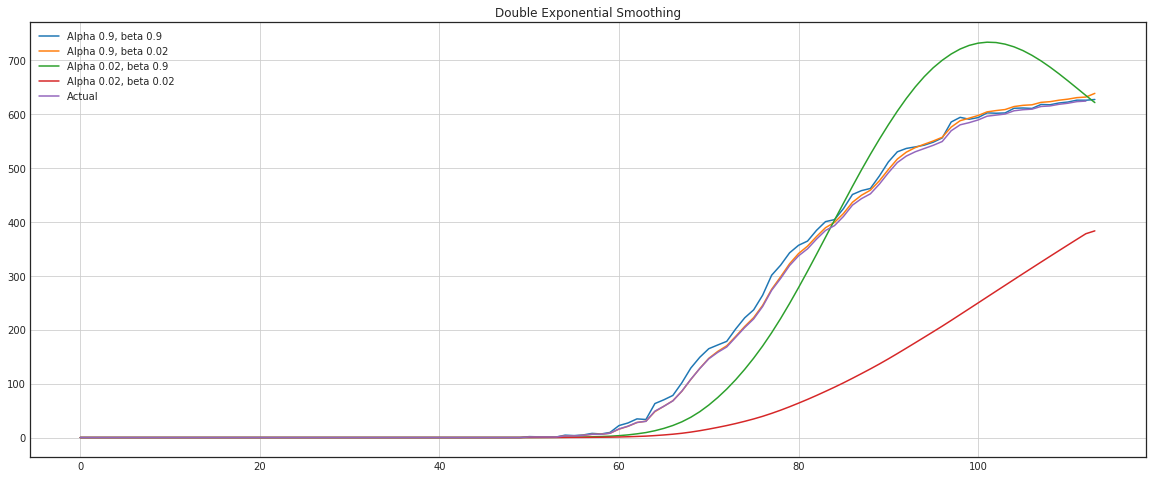

In [24]:
plotDoubleExponentialSmoothing(tsf[10].target, alphas=[0.9, 0.02], betas=[0.9, 0.02])

### Triple Exponential Smoothing (Holt-Winters)

In [25]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [26]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=7):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [27]:
# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(tsf[10].target[:-7], mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(tsf[10].target[:-7], slen = 7, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 14, scaling_factor = 3)
model.triple_exponential_smoothing()

0.890742689559456 0.06083895848353105 1.0


In [28]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Error: {0:.2f}".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-7, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

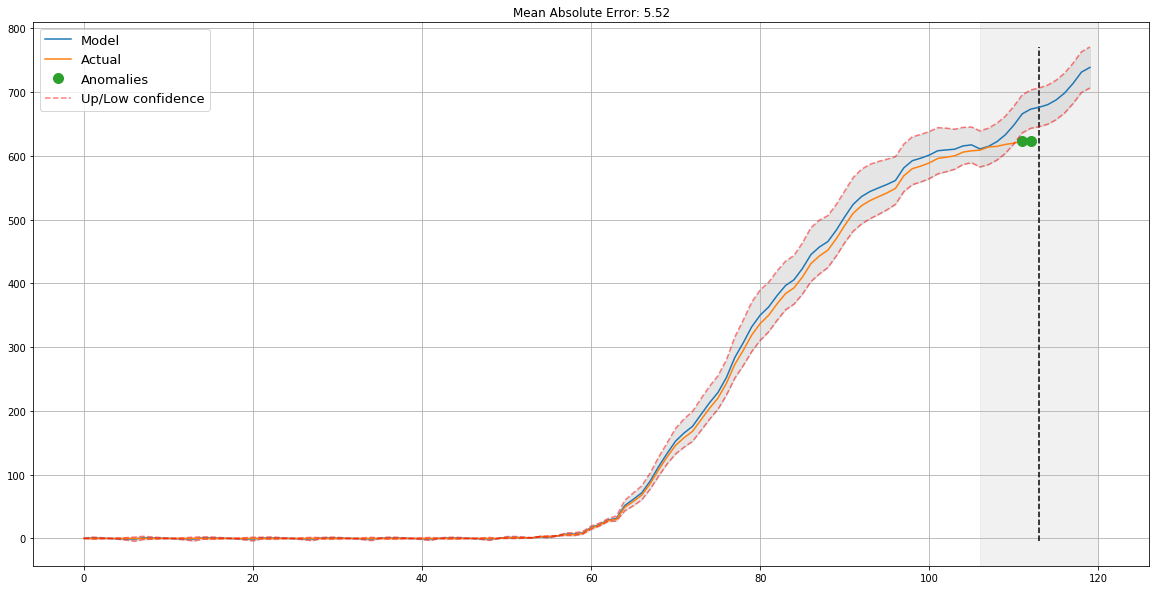

In [29]:
plotHoltWinters(tsf[10].target, plot_intervals=True, plot_anomalies=True)

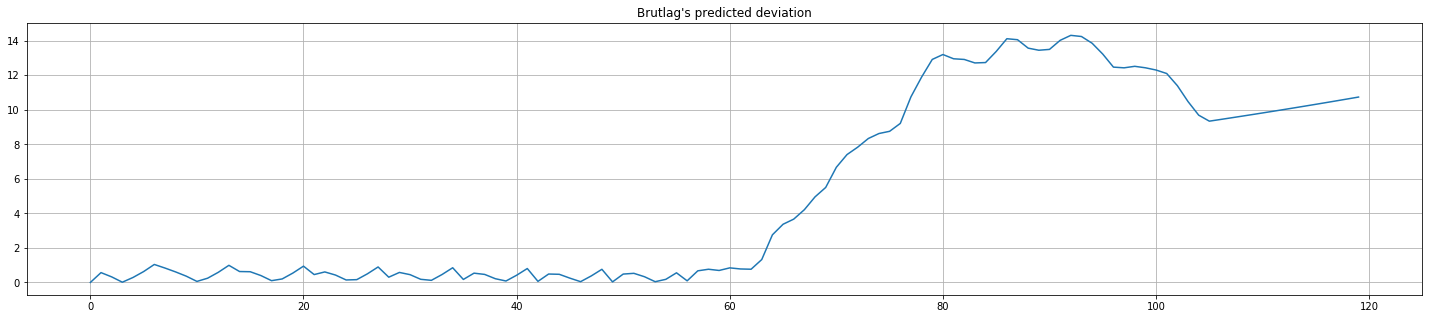

In [30]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

Interpretation : À en juger par les graphes, notre modèle a réussi à approximer avec succès la série temporelle initiale, capturant la saisonnalité hebdomadaire, la tendance globale à la baisse et même certaines anomalies. Si vous regardez les écarts du modèle, vous pouvez clairement voir que le modèle réagit assez fortement aux changements dans la structure de la série, puis ramène rapidement l'écart aux valeurs normales, "oubliant" essentiellement le passé. Cette fonctionnalité du modèle nous permet de construire rapidement des systèmes de détection d'anomalies, même pour les données de série bruyantes, sans dépenser trop de temps et d'argent pour préparer les données et entraîner le modèle.

### Evaluation

In [31]:
pred_list = []
for t in tsf :
    model = HoltWinters(t.target[:-7], slen = 7, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 7, scaling_factor = 3)
    model.triple_exponential_smoothing()
    prediction = pd.DataFrame(data=model.result[-7:],columns=['target'])
    pred_list.append(prediction)


In [32]:
prediction_target = pd.concat(pred_list).reset_index(drop=True)
predictions = test.copy()
predictions['target'] = np.ceil(prediction_target)
predictions.fillna(0,inplace=True)
predictions['target'] = predictions['target'].astype(int)
predictions.loc[predictions['target']<0,'target'] = 0

In [33]:
print('R2 score: ', r2_score(test['target'], predictions['target']))
print('MSE: ', mean_squared_error(test['target'], predictions['target']))
print('MAE: ', mean_absolute_error(test['target'], predictions['target']))

R2 score:  0.9991997467074303
MSE:  37516.86534518113
MAE:  39.13465481886534


On calcule le Mean Absolute Error, qui représente la précision de notre modèle. On a MAE = 39.13 et R-sqaured = 0.999 ce qui signifie que notre modèle prédit avec une bonne précision le futur. On va maintenant passer à une modèle d'auto-régression ARIMA qui peut nous donner un meilleur résultat.

## Time Series Forecasting SARIMA

Les modèles ARIMA saisonniers sont généralement notés SARIMA (p, d, q) (P, D, Q, m), où les paramètres p, d et q sont des nombres entiers non négatifs, p est l'ordre (nombre de décalages) de l'autorégressif modèle, d est le degré de différenciation (le nombre de fois où les données ont eu des valeurs passées soustraites), et q est l'ordre du modèle de moyenne mobile et où m se réfère au nombre de périodes dans chaque saison, et le P, D, Q font référence aux termes autorégressifs, de différenciation et de moyenne mobile pour la partie saisonnière du modèle ARIMA.

### Getting rid of non-stationarity

D'après la partie précédente, la saisonnalité visible est inexistante. Cependant, la fonction d'autocorrélation a encore trop de retards importants. Pour les supprimer, nous prendrons les premières différences, en soustrayant la série d'elle-même avec le décalage d'un mois (30 jours).

In [34]:
tsfdiff = []
for t in tsf:
    tsfdiff.append(t-t.shift(30+2))

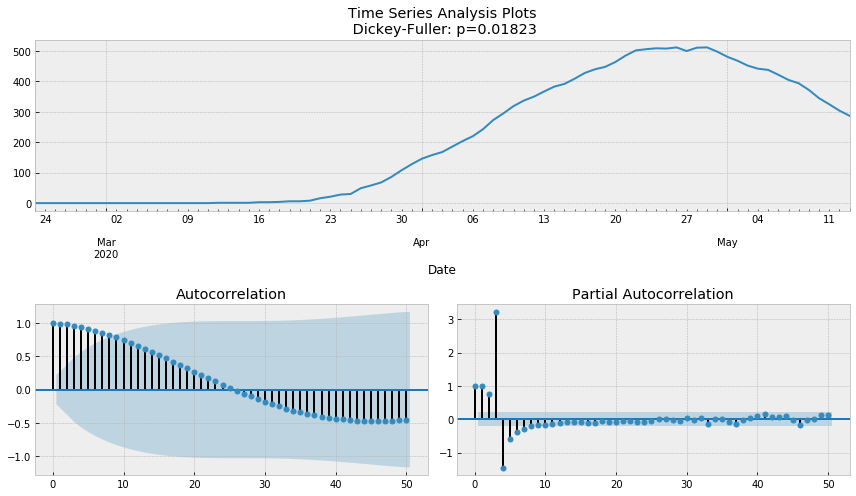

In [35]:
tsplot(tsfdiff[10][30+2:].target, lags=50)

Notre série ressemble maintenant à quelque chose d'indescriptible, oscillant autour de zéro. Le test de Dickey-Fuller indique qu'il est stationnaire et le nombre de pics significatifs dans ACF a chuté après une seule différentiation saisonniaires et 2 diffférentation non saisonniaire. On peut maintenant deviner les hyperparamètres du modèle ARIMA.

### Hyperparameters tuning

- p est très probablement 8 (ou 9) puisqu'il s'agit du dernier retard significatif sur le PACF, après quoi la plupart des autres ne sont pas significatifs.
- d est égal à 0 parce que nous avons eu 2 différentiations non saisonniaires
- q devrait se situer autour de 9 ainsi que sur l'ACF
- P (seasonal) pourrait être 1, car les décalages des 24 e et 48 e sont quelque peu significatifs sur le PACF
- D (seasonal) est à nouveau égal à 1 parce que nous avons effectué une différenciation saisonnière (par 30 jours) pour rendre la série temporelle stationnaire
- Q (seasonal) est probablement 1. Le 30eme décalage sur ACF est significatif tandis que le 60eme ne l'est pas.
- m est 30 comme elle représente la durée de notre période

On choisit le modèle qui a la valuer AIC la plus faible => SAIRMA (8,2,9)x(1,1,1,30)

### SARIMA Test on one series

In [36]:
mod = sm.tsa.statespace.SARIMAX(ts[10],
                                order=(8, 2, 9),
                                seasonal_order=(1, 1, 1, 30),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.aic)
print(results.summary().tables[1])

217.45643358199584
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0222     12.242     -0.002      0.999     -24.016      23.972
ar.L2         -0.7393     10.361     -0.071      0.943     -21.046      19.568
ar.L3          0.4743     15.707      0.030      0.976     -30.311      31.260
ar.L4         -0.2820     18.164     -0.016      0.988     -35.883      35.319
ar.L5         -0.0272     16.212     -0.002      0.999     -31.803      31.748
ar.L6         -0.0511     10.614     -0.005      0.996     -20.854      20.752
ar.L7         -0.1355      7.928     -0.017      0.986     -15.673      15.402
ar.L8          0.1204      3.546      0.034      0.973      -6.830       7.071
ma.L1         -0.0555     82.601     -0.001      0.999    -161.950     161.839
ma.L2          0.3345    110.960      0.003      0.998    -217.143     217.812
ma.L3         -0.9833    151.142 

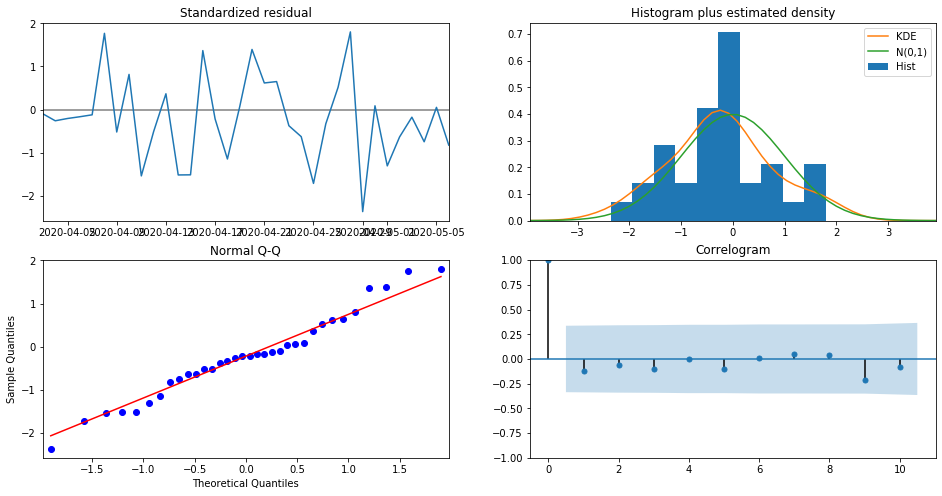

In [37]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

On peut déduire que ce modèle est adéquat comme l'erreur est sous forme bruit blanc, l'auto-corrélation est inexistante, l'histogramme de densité forme presque une loi normale centré réduite et le modèle passe par la plupart des quantiles théoriques.

In [44]:
pred = results.get_prediction(start='2020-05-06',end='2020-05-23',dynamic=False)
pred_ci = pred.conf_int()
print(pred.predicted_mean)
print("\n")
print(pred_ci)

2020-05-06    610.395913
2020-05-07    609.438814
2020-05-08    609.271865
2020-05-09    608.221523
2020-05-10    607.299486
2020-05-11    607.923121
2020-05-12    606.218890
2020-05-13    605.066575
2020-05-14    604.912541
2020-05-15    605.166984
2020-05-16    603.008226
2020-05-17    602.063603
2020-05-18    601.433339
2020-05-19    599.812825
2020-05-20    599.340279
2020-05-21    602.036897
2020-05-22    603.559874
2020-05-23    607.980365
Freq: D, dtype: float64


            lower target  upper target
2020-05-06    604.688964    616.102861
2020-05-07    603.731950    615.145679
2020-05-08    596.845218    621.698512
2020-05-09    589.450911    626.992135
2020-05-10    583.459967    631.139004
2020-05-11    579.113270    636.732971
2020-05-12    571.927923    640.509856
2020-05-13    564.996841    645.136309
2020-05-14    558.295949    651.529133
2020-05-15    550.212666    660.121302
2020-05-16    537.907526    668.108925
2020-05-17    525.845308    678.281898
2020-05-18    513

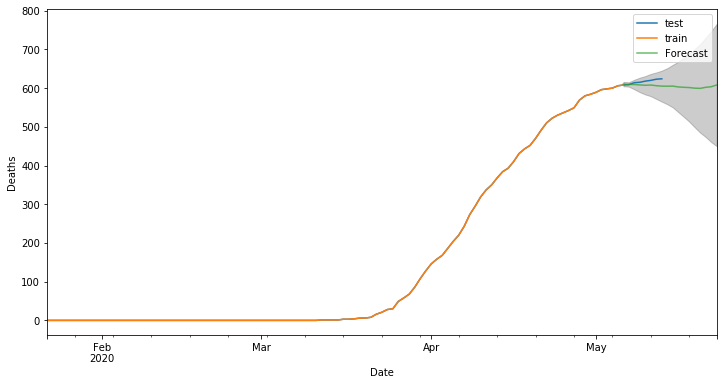

In [45]:
ax = tsf[10].target.plot(label='test',figsize=(12,6))
ts[10].target.plot(ax=ax, label='train')
pred.predicted_mean.plot(ax=ax,label='Forecast', alpha=.7)


ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
plt.legend()

plt.show()

### Applying the SARIMA model to the whole data

In [29]:
pred_list = []
pred_list2 = []
for t in ts:
    mod = sm.tsa.statespace.SARIMAX(t,
                                order=(8, 2, 9),
                                seasonal_order=(1, 1, 1, 30),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    pred = results.get_prediction(start=pd.to_datetime('2020-05-07'),end='2020-05-13',dynamic=False)
    prediction = pd.DataFrame(data=pred.predicted_mean,columns=['target'])
    pred_list.append(prediction)
    pred2 = results.get_prediction(start=pd.to_datetime('2020-04-20'),end='2020-06-07',dynamic=False)
    prediction2 = pd.DataFrame(data=pred2.predicted_mean,columns=['target'])
    pred_list2.append(prediction2)

prediction_target = pd.concat(pred_list).reset_index(drop=True)
prediction_target2 = pd.concat(pred_list2).reset_index(drop=True)

In [30]:
predictions = test.copy()
predictions['target'] = np.ceil(prediction_target)
predictions.fillna(0,inplace=True)
predictions['target'] = predictions['target'].astype(int)
predictions.loc[predictions['target']<0,'target'] = 0

In [31]:
predictions.head()

,Territory X Date,target
0,Afghanistan X 5/7/20,113
1,Afghanistan X 5/8/20,122
2,Afghanistan X 5/9/20,130
3,Afghanistan X 5/10/20,141
4,Afghanistan X 5/11/20,151


### Evaluation

In [32]:
print('R2 score: ', r2_score(test['target'], predictions['target']))
print('MSE: ', mean_squared_error(test['target'], predictions['target']))
print('MAE: ', mean_absolute_error(test['target'], predictions['target']))

R2 score:  0.9988988634457604
MSE:  51622.64524948735
MAE:  35.75393028024607


On calcule le Mean Absolute Error, qui représente la précision de notre modèle. On a MAE = 35.75 et R-sqaured = 0.998 ce qui signifie que notre modèle prédit avec une bonne précision le futur.

## Preparing a 'sample submission' file and scoring locally

In [33]:
print(test.target.sum())
ss = predictions.copy()
print(ss.target.sum())
ss.to_csv('SampleSubLocal.csv', index=False)

1981590
2024736


## Matching the Zindi Submission File

In [37]:
dates = pd.date_range(start='2020-04-20', end='2020-06-07', freq='1d')
ids = []
for c in sorted(train['Territory'].unique()):
    for d in dates:
        ids.append(c + ' X ' + d.strftime('%#m/%#d/%y'))
ss2 = pd.DataFrame({
    'Territory X Date':ids,
    'target':0
})
ss2['target'] = np.ceil(prediction_target2)
ss2.fillna(0,inplace=True)
ss2['target'] = ss2['target'].astype(int)
ss2.loc[ss2['target']<0,'target'] = 0
ss2.to_csv('SampleSubmission.csv', index=False)